In [7]:
################################################################################
# Load dataset and split it into training and test set
################################################################################

import pandas as pd
import os
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder

sample_size = 10000

# Load dateset
df = pd.read_csv(os.getcwd() + f'/data/sample-{sample_size}-2.csv')

# Encode categorical columns
label_encoder = LabelEncoder()
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

# Split dataset according to attack type
normal_df = df[df['Target'] == 0]
attack_df = df[df['Target'] == 1]

# Split dataset into training and test set
normal_df_train = normal_df.sample(frac=0.8, random_state=42)
normal_df_test = normal_df.drop(normal_df_train.index)
attack_df_train = attack_df.sample(frac=0.8, random_state=42)
attack_df_test = attack_df.drop(attack_df_train.index)

X_train = pd.concat([normal_df_train, attack_df_train]).drop(columns=['Target', 'Traffic'])
y_train = pd.concat([normal_df_train, attack_df_train])['Target']
X_test = pd.concat([normal_df_test, attack_df_test]).drop(columns=['Target', 'Traffic'])
y_test = pd.concat([normal_df_test, attack_df_test])['Target']

print("Training set size: ", X_train.shape[0])
print("Test set size: ", X_test.shape[0])
# print(X_train.columns)

Training set size:  8000
Test set size:  2000


# Feature Importance

In [ ]:
################################################################################
# Feature Importance - Decision Tree 
################################################################################

from sklearn.tree import DecisionTreeClassifier

n = 100

feature_importances = {}
for i in range(n):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    sorted_features = sorted(zip(model.feature_importances_, model.feature_names_in_), reverse=True)
    for importance, name in sorted_features:
        if name in feature_importances:
            feature_importances[name].append(importance)
        else:
            feature_importances[name] = [importance]

average_feature_importances = {}
for name, importances in feature_importances.items():
    average_feature_importances[name] = sum(importances) / len(importances)

top_features = sorted(average_feature_importances.items(), key=lambda x: x[1], reverse=True)

with open(f"results/feature-importance-{sample_size}-dt.txt", "a") as f:
    f.write("\n".join([str(feature) for feature in top_features[:5]]))

print(top_features[:5])

In [ ]:
################################################################################
# Feature Importance - Random Forest
################################################################################

from sklearn.ensemble import RandomForestClassifier

n = 100

feature_importances = {}
for i in range(n):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    sorted_features = sorted(zip(model.feature_importances_, model.feature_names_in_), reverse=True)
    for importance, name in sorted_features:
        if name in feature_importances:
            feature_importances[name].append(importance)
        else:
            feature_importances[name] = [importance]

average_feature_importances = {}
for name, importances in feature_importances.items():
    average_feature_importances[name] = sum(importances) / len(importances)

top_features = sorted(average_feature_importances.items(), key=lambda x: x[1], reverse=True)

with open(f"results/feature-importance-{sample_size}-rf.txt", "a") as f:
    f.write("\n".join([str(feature) for feature in top_features[:5]]))

print(top_features[:5])

In [8]:
################################################################################
# Permutation Feature Importance
################################################################################

import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Feature names
feature_names = X_train.columns

# Initialize the models
models = {
    "LR": LogisticRegression(random_state=42),
    "DT": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "KNN": KNeighborsClassifier(),
}

# DataFrame to store feature importances
importances_df = pd.DataFrame(index=feature_names)

# Compute permutation feature importance for each model
for model_name, model in models.items():
    print(f"Computing permutation feature importance for {model_name}...")
    # Fit the model
    model.fit(X_train, y_train)
    
    # Compute permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    
    # Store the mean importance values
    importances_df[model_name] = result.importances_mean

    # Normalize the importance values
    min_val = importances_df[model_name].abs().min()
    max_val = importances_df[model_name].abs().max()
    if max_val - min_val == 0:
        importances_df[model_name+"_minmax_normalized"] = importances_df[model_name]
    else:
        importances_df[model_name+"_minmax_normalized"] = (importances_df[model_name].abs() - min_val) / (max_val - min_val)


# Display the feature importances DataFrame
# print("Permutation Feature Importances:")
# print(importances_df)

# Compute the mean importance considering absolute value and add it as a new column
normalized_columns = [col for col in importances_df.columns if '_minmax_normalized' in col]
importances_df["Mean"] = importances_df[normalized_columns].mean(axis=1)

# Sort the values based on the mean importance
importances_sorted_df = importances_df.sort_values(by="Mean", ascending=False)

Computing permutation feature importance for LR...


c:\Users\S4025371\OneDrive - RMIT University\Repositories\iot-llm\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Computing permutation feature importance for DT...
Computing permutation feature importance for RF...
Computing permutation feature importance for SVM...
Computing permutation feature importance for KNN...


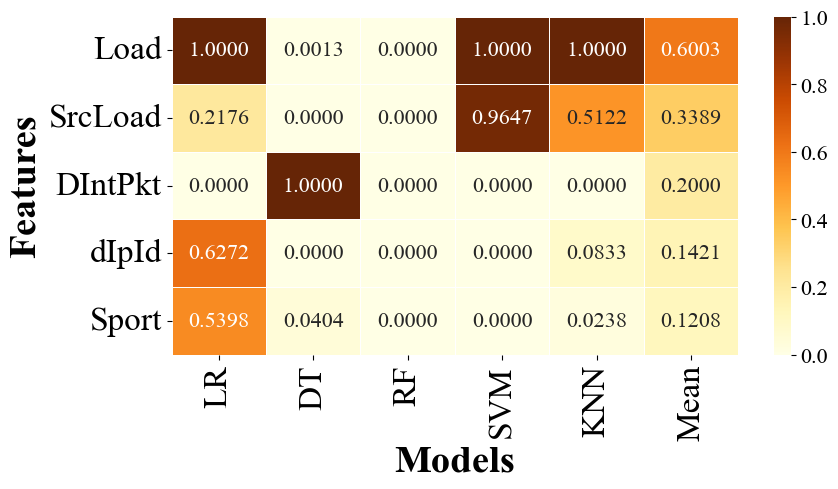

In [11]:
# Visualize the feature importances using a heatmap
plt.figure(figsize=(9, 5))
sns.heatmap(
    importances_sorted_df[["LR_minmax_normalized", "DT_minmax_normalized", "RF_minmax_normalized", "SVM_minmax_normalized", "KNN_minmax_normalized", "Mean"]].head(5),
    annot=True,
    annot_kws={"size": 16},
    cmap="YlOrBr",
    fmt=".4f",
    linewidths=0.5,
    linecolor='white'
)
plt.xlabel("Models", fontdict={'fontweight': 'bold', 'fontsize': 28})
plt.ylabel("Features", fontdict={'fontweight': 'bold', 'fontsize': 28})
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], labels=['LR', 'DT', 'RF', 'SVM', 'KNN', 'Mean'], rotation=90)
plt.yticks(rotation=0)
plt.tick_params(axis='both', labelsize=24)
plt.gcf().axes[-1].tick_params(labelsize=16)
plt.tight_layout()
plt.rcParams['font.family'] = 'times new roman'
plt.savefig("../charts/WUSTL-IIoT-2021-feature-importance.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [12]:
importances_sorted_df.to_csv(f"results/feature-importance-{sample_size}-permutation.csv")
import requests
import json

def notifyMe(title, body, thumbnail, otn, accessKey):
    url = "https://www.appsheet.com/api/v2/apps/520fb099-21b2-4c4f-80df-08196ccd1dcf/tables/Notifications/Action?applicationAccessKey=" + accessKey
    headers = {
        'Content-Type': 'application/json',
    }
    data = {
        "Action": "Add",
        "Properties": {
            "Locale": "en-US",
            "Timezone": "AUS Eastern Standard Time"
        },
        "Rows": [
            {
                "Title": title,
                "Body": body,
                "Thumbnail": thumbnail,
                "OTN": otn
            }
        ]
    }
    requests.post(url, headers=headers, data=json.dumps(data))

notifyMe("VS Code", "Cell run completed.", "", True, "V2-M1rRp-PsQiG-5sMA1-u7dSz-Yebh2-gVdsL-gGkSy-6JKYY")


# Prediction

In [3]:
################################################################################
# Predict from Logistic Regression model
################################################################################

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import time

n = 10
avg_elapsed_time = []
avg_macro_f1 = []
for i in range(n):
    # Create an instance of the DecisionTreeClassifier model
    model = LogisticRegression()

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict the labels for the test data
    y_true = y_test
    start = time.time()
    y_pred = model.predict(X_test)
    end = time.time()
    avg_elapsed_time.append(end - start)

    # Evaluate the model
    c_report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    c_matrix = confusion_matrix(y_true, y_pred)
    avg_macro_f1.append(c_report['macro avg']['f1-score'])

    with open(f"results/ml/result-lr-{sample_size}-2.txt", "a") as f:
        f.write(f"Classication Report\n{c_report}\n\nConfusion Matrix\n{c_matrix}\n\n")

    # print(c_report)
    # print(c_matrix)

print("Time taken: ", sum(avg_elapsed_time)/n)
print("Macro F1: ", sum(avg_macro_f1)/n)

c:\Users\S4025371\OneDrive - RMIT University\Repositories\iot-llm\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\S4025371\OneDrive - RMIT University\Repositories\iot-llm\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

Time taken:  0.006421017646789551
Macro F1:  0.9494499715656091


c:\Users\S4025371\OneDrive - RMIT University\Repositories\iot-llm\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [4]:
################################################################################
# Predict from Decision Tree model
################################################################################

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time

n = 10
avg_elapsed_time = []
avg_macro_f1 = []
for i in range(n):
    # Create an instance of the DecisionTreeClassifier model
    model = DecisionTreeClassifier()

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict the labels for the test data
    y_true = y_test
    start = time.time()
    y_pred = model.predict(X_test)
    end = time.time()
    avg_elapsed_time.append(end - start)

    # Evaluate the model
    c_report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    c_matrix = confusion_matrix(y_true, y_pred)
    avg_macro_f1.append(c_report['macro avg']['f1-score'])

    with open(f"results/ml/result-dt-{sample_size}-2.txt", "a") as f:
        f.write(f"Classication Report\n{c_report}\n\nConfusion Matrix\n{c_matrix}\n\n")

    # print(c_report)
    # print(c_matrix)

print("Time taken: ", sum(avg_elapsed_time)/n)
print("Macro F1: ", sum(avg_macro_f1)/n)

Time taken:  0.007949256896972656
Macro F1:  1.0


In [5]:
################################################################################
# Predict from Random Forest model
################################################################################

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time

n = 10
avg_elapsed_time = []
avg_macro_f1 = []
for i in range(n):
    # Create an instance of the DecisionTreeClassifier model
    model = RandomForestClassifier()

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict the labels for the test data
    y_true = y_test
    start = time.time()
    y_pred = model.predict(X_test)
    end = time.time()
    avg_elapsed_time.append(end - start)

    # Evaluate the model
    c_report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    c_matrix = confusion_matrix(y_true, y_pred)
    avg_macro_f1.append(c_report['macro avg']['f1-score'])

    with open(f"results/ml/result-rf-{sample_size}-2.txt", "a") as f:
        f.write(f"Classication Report\n{c_report}\n\nConfusion Matrix\n{c_matrix}\n\n")

    # print(c_report)
    # print(c_matrix)

print("Time taken: ", sum(avg_elapsed_time)/n)
print("Macro F1: ", sum(avg_macro_f1)/n)

Time taken:  0.08234355449676514
Macro F1:  0.9999449999998875


In [6]:
################################################################################
# Predict from SVM model
################################################################################

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import time

n = 10
avg_elapsed_time = []
avg_macro_f1 = []
for i in range(n):
    # Create an instance of the DecisionTreeClassifier model
    model = SVC()

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict the labels for the test data
    y_true = y_test
    start = time.time()
    y_pred = model.predict(X_test)
    end = time.time()
    avg_elapsed_time.append(end - start)

    # Evaluate the model
    c_report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    c_matrix = confusion_matrix(y_true, y_pred)
    avg_macro_f1.append(c_report['macro avg']['f1-score'])

    with open(f"results/ml/result-svm-{sample_size}-2.txt", "a") as f:
        f.write(f"Classication Report\n{c_report}\n\nConfusion Matrix\n{c_matrix}\n\n")

    # print(c_report)
    # print(c_matrix)

print("Time taken: ", sum(avg_elapsed_time)/n)
print("Macro F1: ", sum(avg_macro_f1)/n)

Time taken:  95.01429414749146
Macro F1:  0.7116178596073199


In [7]:
################################################################################
# Predict from kNN model
################################################################################

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time

n = 10
avg_elapsed_time = []
avg_macro_f1 = []
for i in range(n):
    # Create an instance of the kNN model
    model = KNeighborsClassifier()

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict the labels for the test data
    y_true = y_test
    start = time.time()
    y_pred = model.predict(X_test)
    end = time.time()
    avg_elapsed_time.append(end - start)

    # Evaluate the model
    c_report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    c_matrix = confusion_matrix(y_true, y_pred)
    avg_macro_f1.append(c_report['macro avg']['f1-score'])

    with open(f"results/ml/result-knn-{sample_size}-2.txt", "a") as f:
        f.write(f"Classication Report\n{c_report}\n\nConfusion Matrix\n{c_matrix}\n\n")

    # print(c_report)
    # print(c_matrix)

print("Time taken: ", sum(avg_elapsed_time)/n)
print("Macro F1: ", sum(avg_macro_f1)/n)

Time taken:  4.470978832244873
Macro F1:  0.997349999675375
